In [1]:
import os.path
#import glob
#from pathlib import Path

import numpy as np
import pandas as pd

from astropy.io import fits

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

from photutils.aperture import EllipticalAnnulus, EllipticalAperture, CircularAperture
from photutils.aperture import aperture_photometry, ApertureStats


In [2]:
obj = 'DQHer'

In [3]:
paramFile = os.path.join('processingParams',obj+'.csv')
params = pd.read_csv(paramFile)

In [13]:
def measureCounts(image, params, semiMinor):
    
    angdeg = params.value[params.param == 'angle'].values[0]
    angrad = angdeg * np.pi / 180.
    pos = (params.value[params.param == 'x'].values[0],
           params.value[params.param == 'y'].values[0])

    axisRatio = (
        params.value[params.param == 'a'].values[0] /
        params.value[params.param == 'b'].values[0]
    )

    semiMajor = semiMinor * axisRatio
    
    ellipse = EllipticalAperture(pos,
                                 semiMajor,
                                 semiMinor,
                                 theta=angrad)
    annulus = EllipticalAnnulus(pos,
                                params.value[params.param == 'ai'].values[0],
                                params.value[params.param == 'ao'].values[0],
                                params.value[params.param == 'bi'].values[0],
                                theta=angrad)
    circle = CircularAperture(pos,
                              params.value[params.param == 'r'].values[0])

    ellipse_stats = ApertureStats(sci, ellipse)
    annulus_stats = ApertureStats(sci, annulus)
    circle_stats = ApertureStats(sci, circle)

    ellipse_area = ellipse_stats.sum_aper_area
    annulus_area = annulus_stats.sum_aper_area
    circle_area = circle_stats.sum_aper_area

    nebula_area = ellipse_area - circle_area
    area_ratio = annulus_area / nebula_area

    ellipse_pho = aperture_photometry(sci, ellipse)
    circle_pho = aperture_photometry(sci, circle)
    bgd_pho = aperture_photometry(sci, annulus)

    ellipse_minus_circle_pho = ellipse_pho['aperture_sum'] - circle_pho['aperture_sum']
    scaled_bgd_pho = bgd_pho['aperture_sum'] / area_ratio
    nebula_pho = ellipse_minus_circle_pho - scaled_bgd_pho
    
    ellipse_var = aperture_photometry(var, ellipse)
    circle_var = aperture_photometry(var, circle)
    nebula_var = ellipse_var['aperture_sum'] - circle_var['aperture_sum']
    #src_var['aperture_sum'].info.format = '%.8g'
    #bgd_var['aperture_sum'].info.format = '%.8g'

    #exptime = header['EXPTIME']
    #ctrt = nebula_pho[0] / exptime # Ha + NII
    #ctrt_err = np.sqrt(nebula_var[0]) / exptime # Ha + NII

    return (nebula_pho[0].value, np.sqrt(nebula_var[0]))


Bgd subtracted Ha (cts/s): 23.159493153908272 p/m 0.14802884697330618
SNR: 156.45256737076787


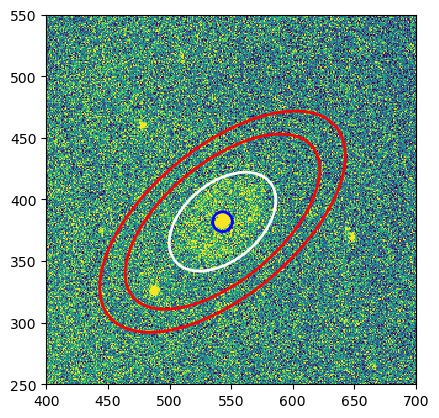

In [15]:
hfile = os.path.join('processed',obj,'H','combined','combined.fits')
hdu = fits.open(hfile)
header = hdu[0].header
sci = hdu[0].data
var = hdu[1].data

angdeg = params.value[params.param == 'angle'].values[0]
angrad = angdeg * np.pi / 180.
pos = (params.value[params.param == 'x'].values[0],
       params.value[params.param == 'y'].values[0])
ellipse = EllipticalAperture(pos,
                             params.value[params.param == 'a'].values[0],
                             params.value[params.param == 'b'].values[0],
                             theta=angrad)
annulus = EllipticalAnnulus(pos,
                            params.value[params.param == 'ai'].values[0],
                            params.value[params.param == 'ao'].values[0],
                            params.value[params.param == 'bi'].values[0],
                            theta=angrad)
circle = CircularAperture(pos,
                          params.value[params.param == 'r'].values[0])

norm = simple_norm(sci, 'linear', percent=90.)
plt.imshow(sci, norm=norm, interpolation='nearest')
plt.xlim(400, 700)
plt.ylim(250, 550)

ap_patches = ellipse.plot(color='white', lw=2,
                           label='Photometry aperture')
an_patches = annulus.plot(color='red', lw=2,
                           label='Photometry annulus')
ci_patches = circle.plot(color='blue', lw=2,
                           label='Photometry star')

ellipse_stats = ApertureStats(sci, ellipse)
annulus_stats = ApertureStats(sci, annulus)
circle_stats = ApertureStats(sci, circle)

ellipse_area = ellipse_stats.sum_aper_area
annulus_area = annulus_stats.sum_aper_area
circle_area = circle_stats.sum_aper_area

nebula_area = ellipse_area - circle_area
area_ratio = annulus_area / nebula_area

ellipse_pho = aperture_photometry(sci, ellipse)
circle_pho = aperture_photometry(sci, circle)
bgd_pho = aperture_photometry(sci, annulus)

ellipse_minus_circle_pho = ellipse_pho['aperture_sum'] - circle_pho['aperture_sum']
scaled_bgd_pho = bgd_pho['aperture_sum'] / area_ratio
nebula_pho = ellipse_minus_circle_pho - scaled_bgd_pho

ellipse_var = aperture_photometry(var, ellipse)
circle_var = aperture_photometry(var, circle)
nebula_var = ellipse_var['aperture_sum'] - circle_var['aperture_sum']
#src_var['aperture_sum'].info.format = '%.8g'
#bgd_var['aperture_sum'].info.format = '%.8g'

exptime = header['EXPTIME']
ctrt = nebula_pho[0] / exptime # Ha + NII
ctrt_err = np.sqrt(nebula_var[0]) / exptime # Ha + NII

NII_correction = 1.18

ctrt = ctrt / NII_correction
ctrt_err = ctrt_err / NII_correction

outFile = os.path.join('processed',obj,'H','combined','CountRate.csv')
df = pd.DataFrame({'CountRate':[ctrt], 'CountRate_Err':[ctrt_err]})
df.to_csv(outFile, index=False)

print('Bgd subtracted Ha (cts/s):', ctrt , 'p/m', ctrt_err)
print('SNR:', ctrt / ctrt_err)

In [27]:
hfile = os.path.join('processed',obj,'H','combined','combined.fits')
hdu = fits.open(hfile)
header = hdu[0].header
sci = hdu[0].data
var = hdu[1].data

semiMajors = np.arange(10,50,0.5)
cts = np.zeros(len(semiMajors))
for i, semiMajor in enumerate(semiMajors):
    cts[i], cts_err = measureCounts(sci, params, semiMajor)

array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
       15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5,
       21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. ,
       26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5,
       32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. ,
       37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5,
       43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. ,
       48.5, 49. , 49.5])

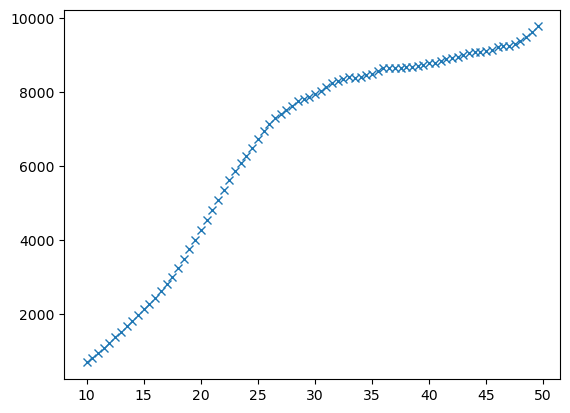

In [28]:
plt.plot(semiMajors, cts, 'x')